P3 <br>
3.1 Write a code to convert the image from the given color model to different color models. <br>
3.2 Include different types of noises in the input image with various densities and apply linear and non-linear spatial filters to the noise contaminated image with different mask size. <br>
<br>
Objective: <br>
The lab objectives include exploring various color models (RGB, CMYK, LAB), simulating common noise types (Gaussian, Salt & Pepper, Speckle), and applying linear and non-linear filters for noise reduction. Students are expected to analyze filter performance with different mask sizes while enhancing their programming skills in Python and OpenCV, and developing effective reporting and presentation skills. <br>
<br>
Scenario: <br>
You are the lead image processing engineer at TechPrint, a company that specializes in producing brochures and posters for technology companies. You are tasked with preparing a product image of a NEW LAPTOP for a high-quality print campaign. The image needs to be converted to various color models used in professional printing and be made noise-free to ensure perfect color reproduction. <br>
<br>
Task breakdown: <br> 
1. Convert an RGB image to multiple color models (CMYK, HSV, LAB, YUV, Grayscale). Add Noise: Introduce Gaussian, Salt & Pepper, poisons and Speckle noise with different densities. <br>
2. Apply Filters: Use linear (box,Gaussian) and non-linear filters (Minimum, Maximum,Median, Bilateral) with varying mask sizes to remove noise. <br>
3. Analyze: Compare the performance of filters in terms of noise reduction and image quality. <br>
4. Report: Summarize the importance of color models, noise impact, and the effectiveness of filters for high-quality printing and digital display.<br> 

1. Image Conversion to Various Color Models

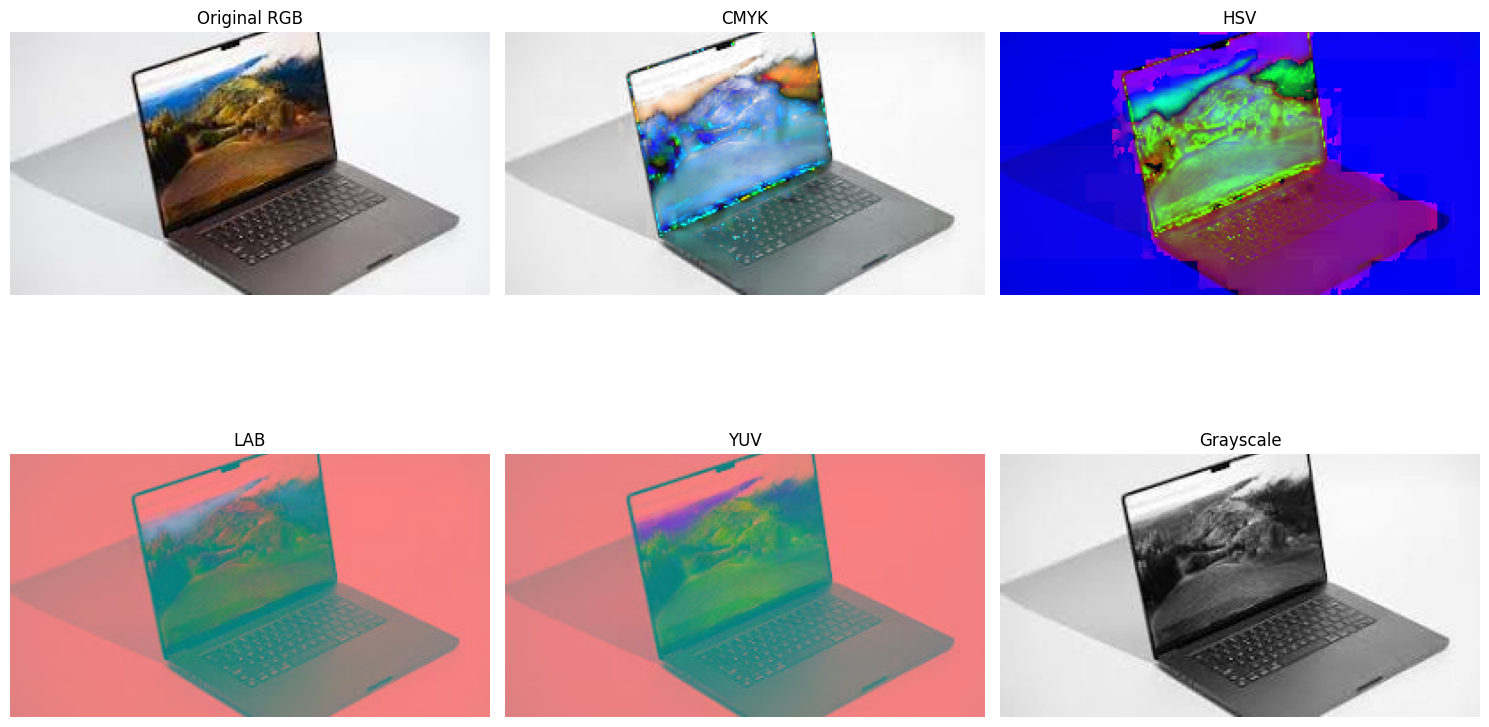

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('laptop.jpg')  # Replace with your image path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display in matplotlib

# Convert to other color models
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# CMYK conversion function
def rgb_to_cmyk(img_rgb):
    img_rgb = img_rgb.astype(np.float32) / 255.0
    K = 1 - np.max(img_rgb, axis=2)
    C = (1 - img_rgb[..., 0] - K) / (1 - K + 1e-8)
    M = (1 - img_rgb[..., 1] - K) / (1 - K + 1e-8)
    Y = (1 - img_rgb[..., 2] - K) / (1 - K + 1e-8)
    CMYK = (np.dstack((C, M, Y, K)) * 255).astype(np.uint8)
    return CMYK

img_cmyk = rgb_to_cmyk(img_rgb)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)



color_models = {
    'Original RGB': img_rgb,
    'CMYK': img_cmyk,
    'HSV': img_hsv,
    'LAB': img_lab,
    'YUV': img_yuv,
    'Grayscale': img_gray
}

plt.figure(figsize=(15, 10))
for idx, (model_name, model_image) in enumerate(color_models.items()):
    plt.subplot(2, 3, idx + 1)
    plt.imshow(model_image if model_name != 'Grayscale' else model_image, cmap='gray')
    plt.title(model_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


Interpretation:<br>

1. RGB: The original image represents how colors are perceived on screens.
2. CMYK: Useful for print; shows how colors are produced by combining cyan, magenta, yellow, and black inks.
3. HSV: Represents color in terms of hue, saturation, and value; useful for tasks like color detection.
4. LAB: More aligned with human vision; provides a perceptually uniform representation.
5. YUV: Separates brightness from color information, often used in video compression.
6. Grayscale: Shows the intensity of light, useful for edge detection and other image processing tasks.

2. Adding Noises

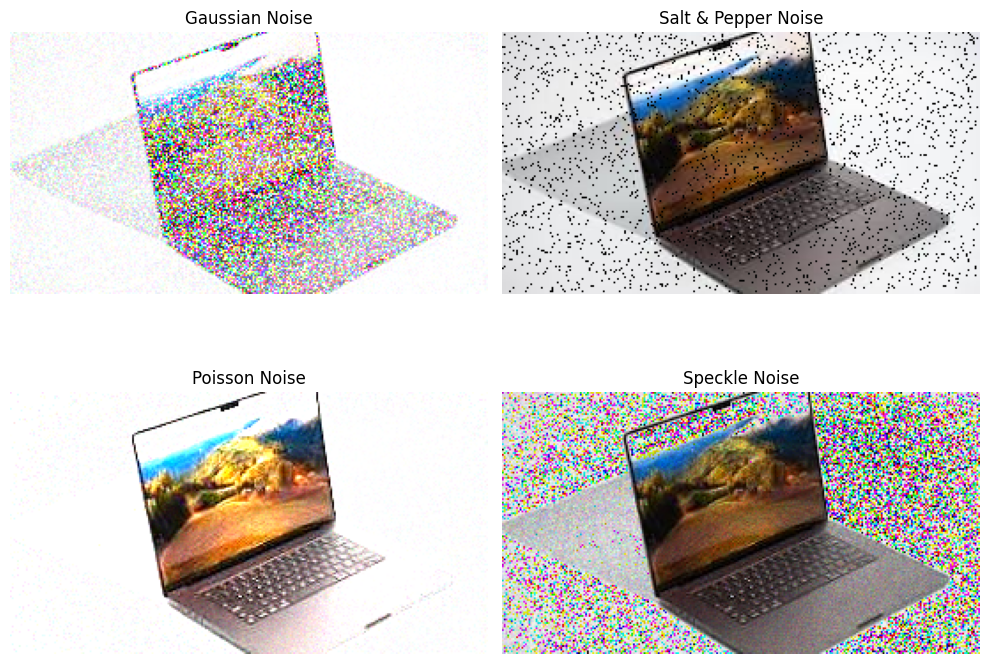

In [12]:
# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, sigma=25):
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

# Function to add Salt and Pepper noise
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    total_pixels = image.size
    num_salt = np.ceil(salt_prob * total_pixels)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 1  # Salt

    num_pepper = np.ceil(pepper_prob * total_pixels)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0  # Pepper

    return noisy_image

# Function to add Poisson noise
def add_poisson_noise(image):
    noise = np.random.poisson(image).astype('uint8')
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Function to add Speckle noise
def add_speckle_noise(image):
    noise = np.random.randn(*image.shape) * 0.1 * image
    noisy_image = image + noise.astype('uint8')
    return noisy_image

# Adding noise to the RGB image
gaussian_noisy_image = add_gaussian_noise(img_rgb)
salt_and_pepper_noisy_image = add_salt_and_pepper_noise(img_rgb, 0.01, 0.01)
poisson_noisy_image = add_poisson_noise(img_rgb)
speckle_noisy_image = add_speckle_noise(img_rgb)


# Visualizing original and noisy images
noisy_images = [gaussian_noisy_image, salt_and_pepper_noisy_image, poisson_noisy_image, speckle_noisy_image]
noisy_image_names = ['Gaussian Noise', 'Salt & Pepper Noise', 'Poisson Noise', 'Speckle Noise']

plt.figure(figsize=(10, 8))
for idx, (name, noisy_image) in enumerate(zip(noisy_image_names, noisy_images)):
    plt.subplot(2, 2, idx + 1)
    plt.imshow(noisy_image)
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()



Interpretation:<br>

1. Gaussian Noise: Appears as random variations in brightness and color; often introduced by sensor noise.
2. Salt & Pepper Noise: Shows as random white and black pixels; commonly seen in image transmission errors.
3. Poisson Noise: Relates to the statistical variation of photon counts; visible in low-light conditions.
4. Speckle Noise: Appears as grainy patterns; often found in radar and ultrasound imaging.

3. Applying Filters

In [3]:
# List of noisy images
noisy_images = [gaussian_noisy_image, salt_and_pepper_noisy_image, poisson_noisy_image, speckle_noisy_image]
noisy_image_names = ['Gaussian Noise', 'Salt & Pepper Noise', 'Poisson Noise', 'Speckle Noise']


In [4]:
# Function to apply various filters
def apply_filters(image):
    # Linear Filters
    box_filter = cv2.boxFilter(image, ddepth=-1, ksize=(5, 5))
    gaussian_filter = cv2.GaussianBlur(image, (5, 5), 0)

    # Non-Linear Filters
    min_filter = cv2.erode(image, np.ones((5, 5), np.uint8))
    max_filter = cv2.dilate(image, np.ones((5, 5), np.uint8))
    median_filter = cv2.medianBlur(image, 5)
    bilateral_filter = cv2.bilateralFilter(image, 9, 75, 75)

    return box_filter, gaussian_filter, min_filter, max_filter, median_filter, bilateral_filter

# Store filter results for each noisy image
all_filter_results = {}

for noisy_image, name in zip(noisy_images, noisy_image_names):
    filtered_images = apply_filters(noisy_image)
    all_filter_results[name] = filtered_images


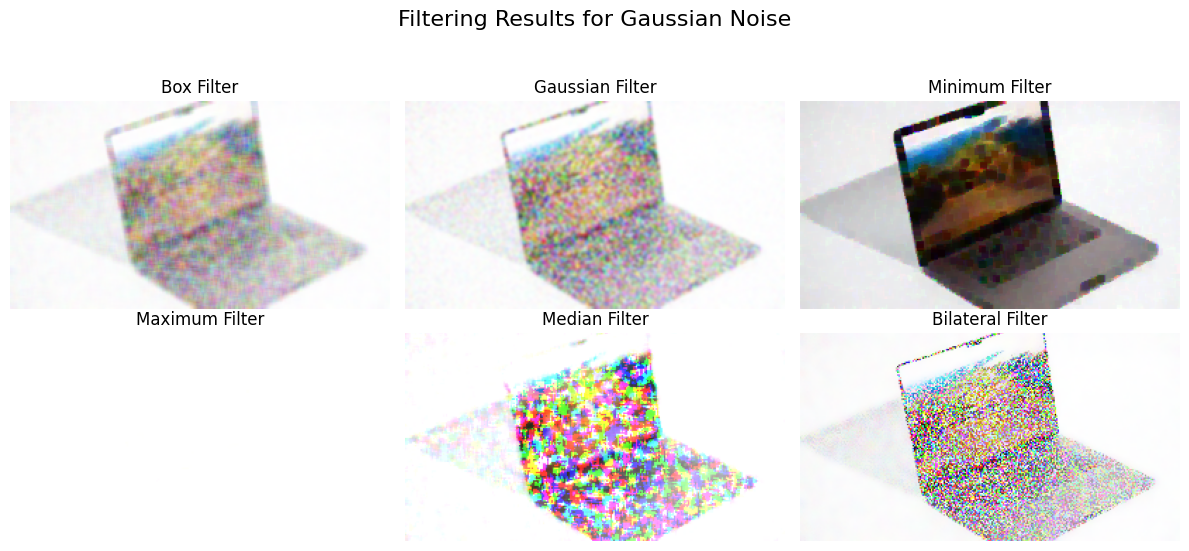

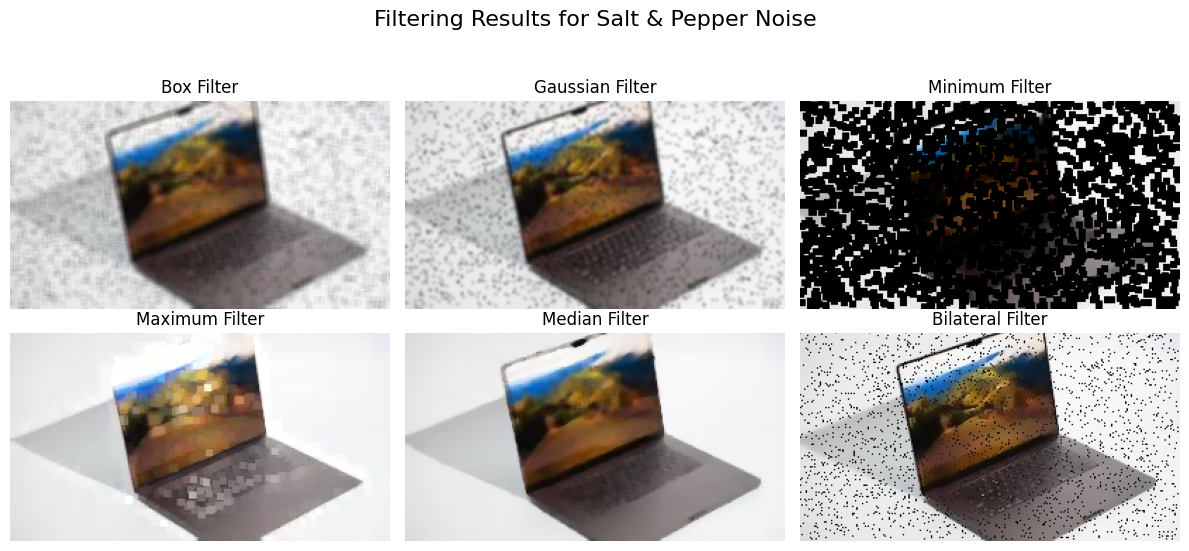

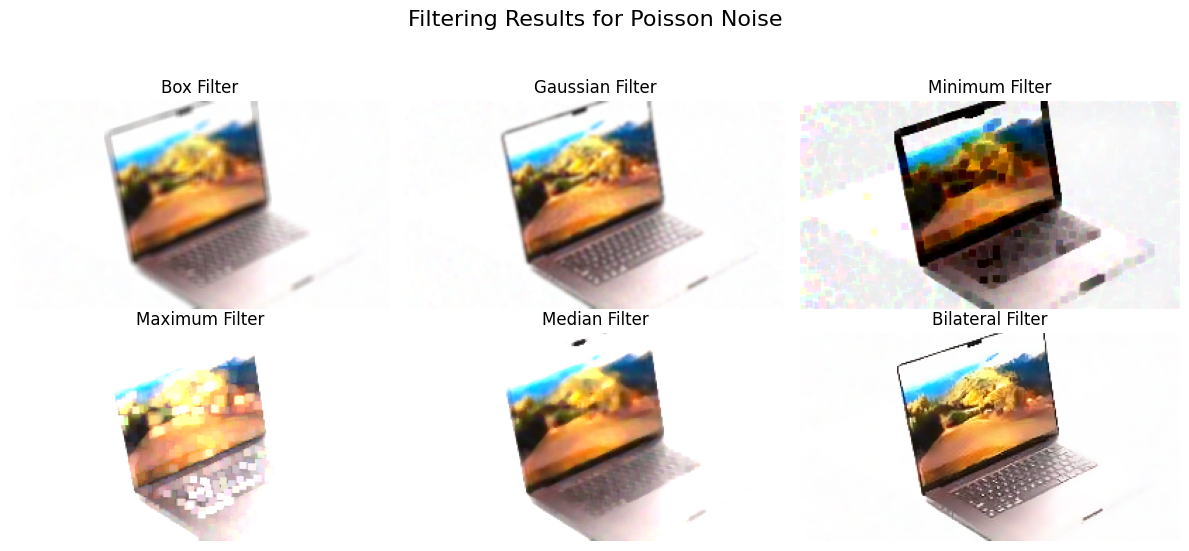

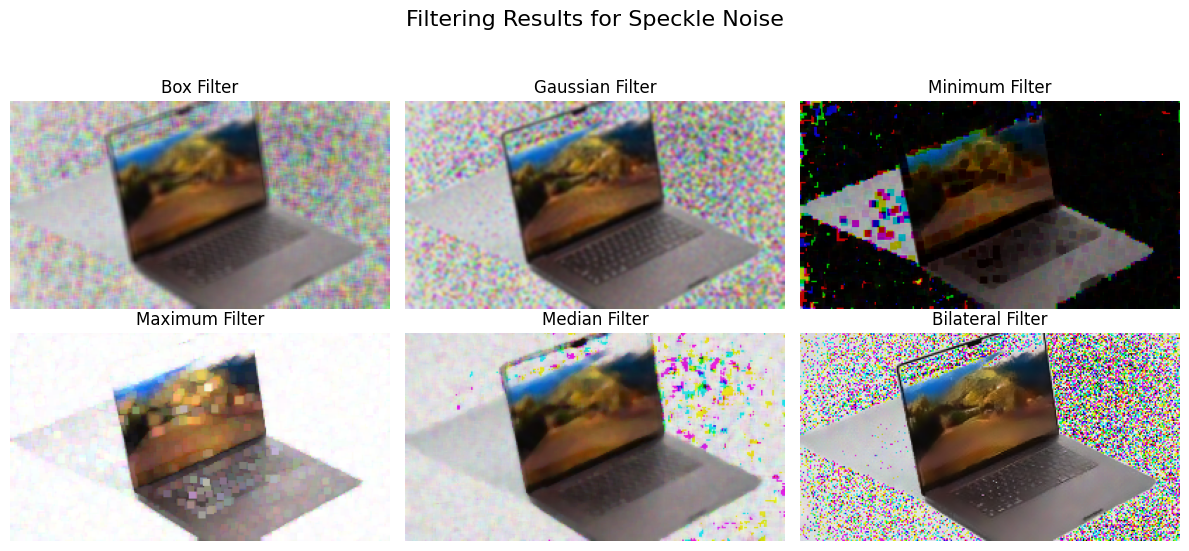

In [5]:
# Plotting the filtered images for each noisy image
num_filters = 6  # Number of filters

for idx, (name, results) in enumerate(all_filter_results.items()):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Filtering Results for {name}', fontsize=16)
    
    for i in range(num_filters):
        plt.subplot(2, 3, i + 1)
        plt.imshow(results[i])
        plt.title(['Box Filter', 'Gaussian Filter', 'Minimum Filter', 'Maximum Filter', 'Median Filter', 'Bilateral Filter'][i])
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
    plt.show()


Interpretation:<br>

Linear:<br>
1. Box Filter: Smooths the image but can blur edges.
2. Gaussian Filter: Reduces noise while preserving edges better than the box filter.<br>

Non-Linear:<br>

3. Minimum Filter: Effective at removing salt-and-pepper noise but can lose details.
4. Maximum Filter: Useful for removing dark spots in images with light noise.
5. Median Filter: Excellent for removing salt-and-pepper noise while retaining edges.
6. Bilateral Filter: Preserves edges while reducing noise, providing a natural look.

4. Analyze Filter Performance

In [6]:
def calculate_mse(original, filtered):
    return np.mean((original.astype('float') - filtered.astype('float')) ** 2)

def calculate_psnr(original, filtered):
    mse = calculate_mse(original, filtered)
    if mse == 0:
        return float('inf')  # Infinite PSNR for identical images
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))


In [8]:
# Assuming you have a clean version of the image for comparison
clean_image = cv2.imread('laptop.jpg')  # Load your clean image here


# Store MSE and PSNR results
performance_metrics = {}

# Calculate metrics for each noisy image's filtered results
for noisy_image_name, filtered_images in all_filter_results.items():
    metrics = []
    for filtered_image in filtered_images:
        mse = calculate_mse(clean_image, filtered_image)
        psnr = calculate_psnr(clean_image, filtered_image)
        metrics.append((mse, psnr))
    performance_metrics[noisy_image_name] = metrics


In [9]:
# Displaying MSE and PSNR results
for noisy_image_name, metrics in performance_metrics.items():
    print(f"\nPerformance Metrics for {noisy_image_name}:")
    for i, (mse, psnr) in enumerate(metrics):
        print(f"Filter {['Box', 'Gaussian', 'Minimum', 'Maximum', 'Median', 'Bilateral'][i]}: MSE = {mse:.2f}, PSNR = {psnr:.2f} dB")



Performance Metrics for Gaussian Noise:
Filter Box: MSE = 4279.26, PSNR = 11.82 dB
Filter Gaussian: MSE = 4291.77, PSNR = 11.80 dB
Filter Minimum: MSE = 1620.50, PSNR = 16.03 dB
Filter Maximum: MSE = 12645.22, PSNR = 7.11 dB
Filter Median: MSE = 6536.52, PSNR = 9.98 dB
Filter Bilateral: MSE = 6100.51, PSNR = 10.28 dB

Performance Metrics for Salt & Pepper Noise:
Filter Box: MSE = 984.98, PSNR = 18.20 dB
Filter Gaussian: MSE = 958.21, PSNR = 18.32 dB
Filter Minimum: MSE = 29147.25, PSNR = 3.48 dB
Filter Maximum: MSE = 1878.02, PSNR = 15.39 dB
Filter Median: MSE = 775.60, PSNR = 19.23 dB
Filter Bilateral: MSE = 2691.64, PSNR = 13.83 dB

Performance Metrics for Poisson Noise:
Filter Box: MSE = 3992.86, PSNR = 12.12 dB
Filter Gaussian: MSE = 3922.86, PSNR = 12.19 dB
Filter Minimum: MSE = 3263.35, PSNR = 12.99 dB
Filter Maximum: MSE = 7645.04, PSNR = 9.30 dB
Filter Median: MSE = 4238.35, PSNR = 11.86 dB
Filter Bilateral: MSE = 3910.31, PSNR = 12.21 dB

Performance Metrics for Speckle Noise

5. Performance Metric Visulaization

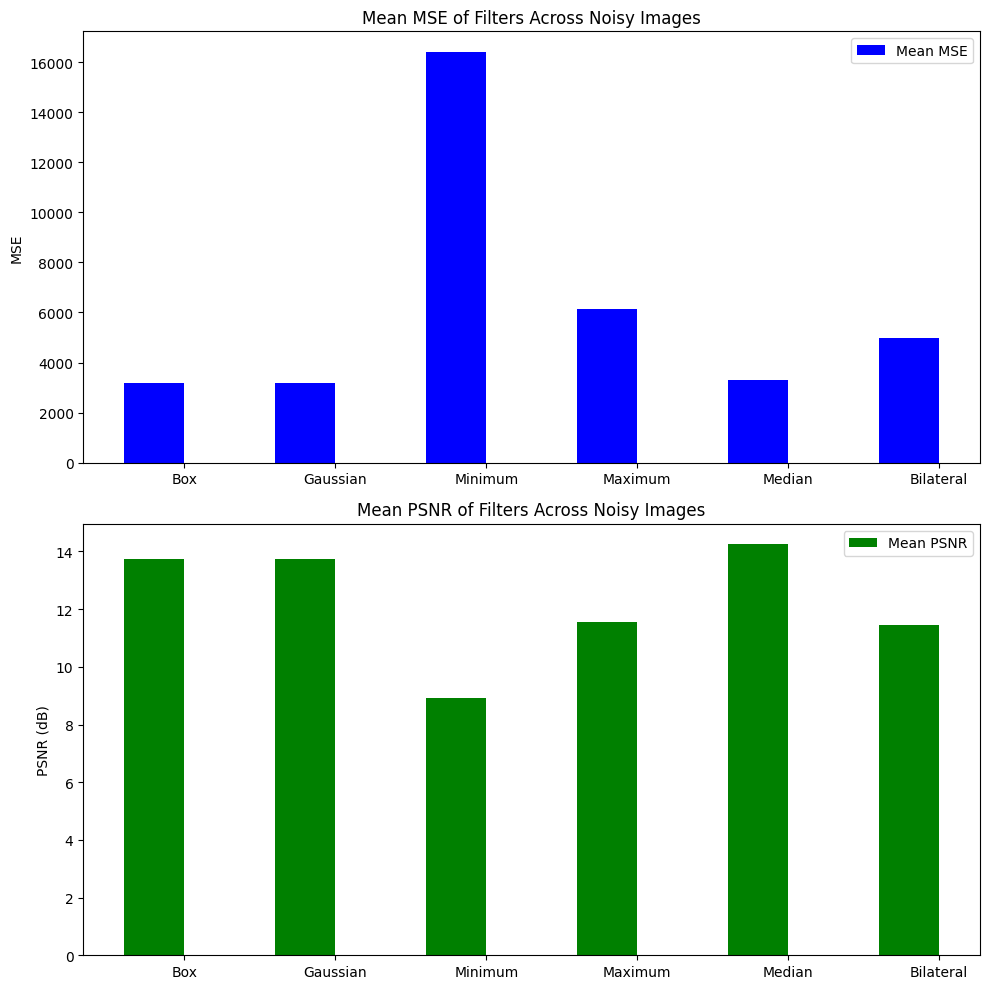

In [15]:
import matplotlib.pyplot as plt

# Performance metrics visualization
filter_names = ['Box', 'Gaussian', 'Minimum', 'Maximum', 'Median', 'Bilateral']
mse_values = np.array([[metrics[0] for metrics in performance_metrics[name]] for name in noisy_image_names])
psnr_values = np.array([[metrics[1] for metrics in performance_metrics[name]] for name in noisy_image_names])

x = np.arange(len(filter_names))  # the label locations

# Create subplots for MSE and PSNR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# MSE Bar Chart
ax1.bar(x - 0.2, mse_values.mean(axis=0), 0.4, label='Mean MSE', color='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(filter_names)
ax1.set_ylabel('MSE')
ax1.set_title('Mean MSE of Filters Across Noisy Images')
ax1.legend()

# PSNR Bar Chart
ax2.bar(x - 0.2, psnr_values.mean(axis=0), 0.4, label='Mean PSNR', color='green')
ax2.set_xticks(x)
ax2.set_xticklabels(filter_names)
ax2.set_ylabel('PSNR (dB)')
ax2.set_title('Mean PSNR of Filters Across Noisy Images')
ax2.legend()

plt.tight_layout()
plt.show()


Interpretation:<br>

1. MSE: Lower values indicate better performance; shows how closely the filtered image matches the original.
2. PSNR: Higher values indicate better quality; reflects the peak signal relative to the noise level. It’s often used as a measure of image quality in compression algorithms.